In [2]:
import glob
import os
import pathlib
import time
import zipfile
import imageio
from matplotlib import cm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import cdist, euclidean
# import requests
# import scipy.ndimage as ndimage
# import tensorflow as tf
# import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Activation, BatchNormalization
# from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
# from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.regularizers import L1, L2
# from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
# # from tensorflow.keras.utils import to_categorical
# from scipy.io import loadmat
import mat73
import tqdm
%matplotlib inline

In [3]:
# Concatenate mat files into a single file
matfiles = []
for file in glob.glob('data/*.mat'):
    mtfile = mat73.loadmat(file)
    mat = {}
    for key, value in mtfile['cjdata'].items():
        mat[key] = value
        matfiles.append(mat)
# with open('brain_tumor_file', 'w') as fout:
#     json.dump(matfiles,fout)

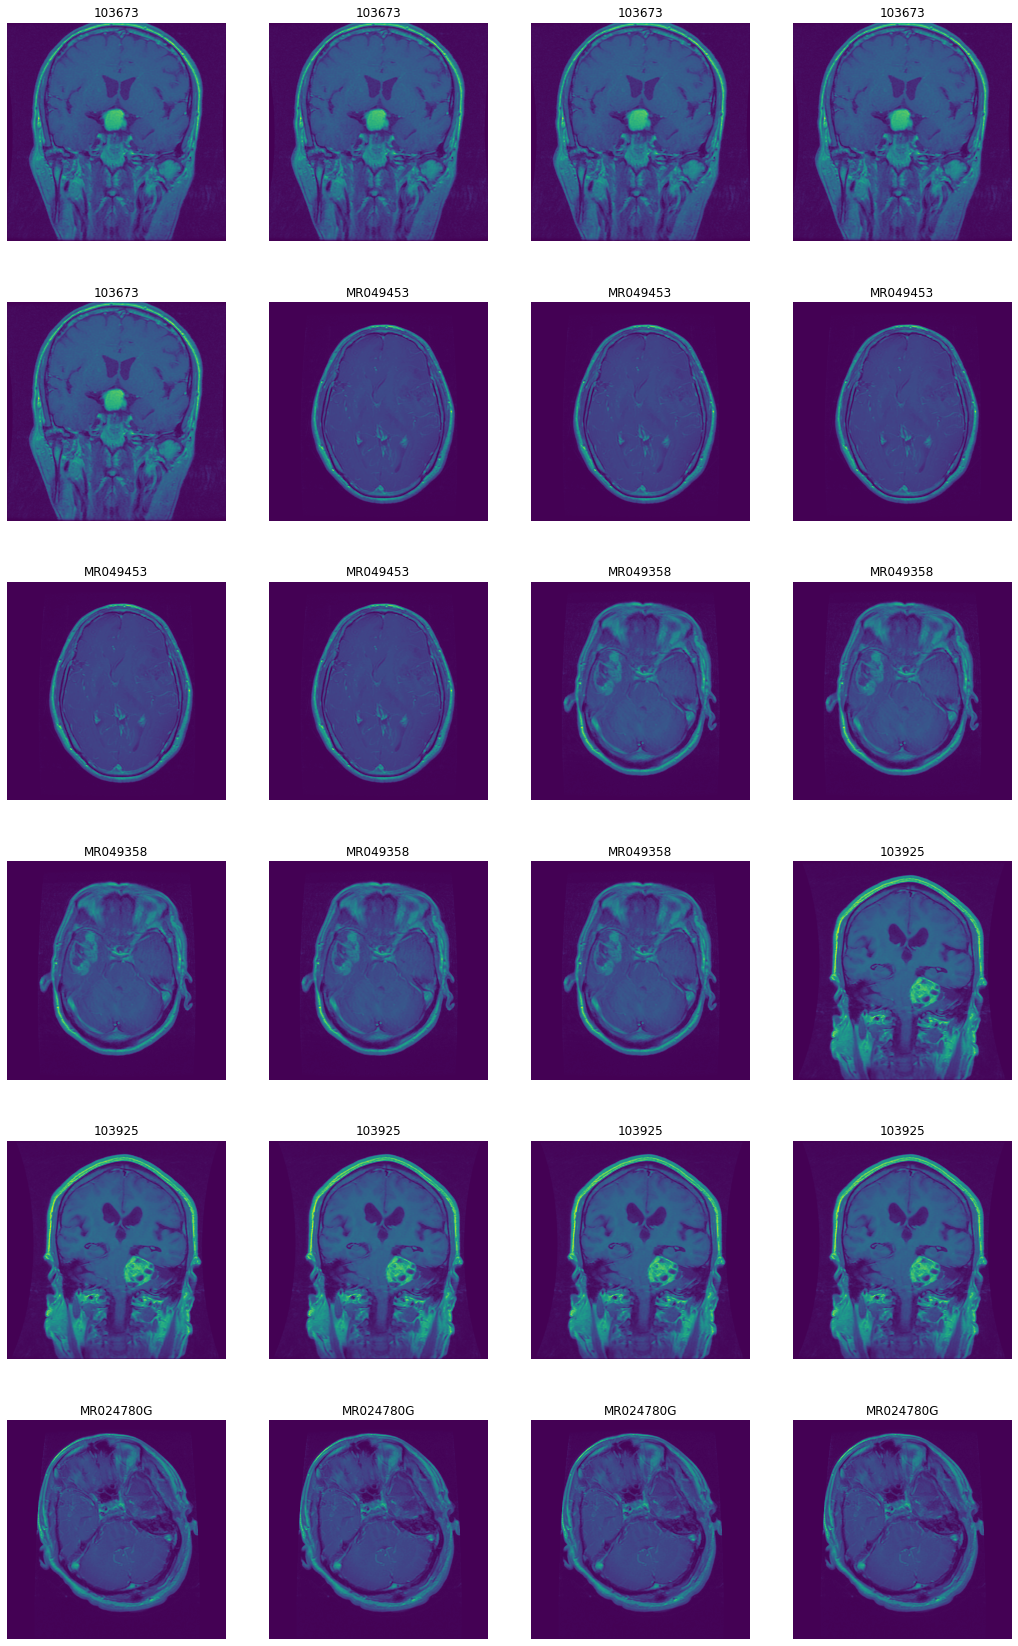

In [3]:
fig, axes= plt.subplots(6,4,figsize=(18,30))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(matfiles[i]['image'])
    ax.set_title(matfiles[i]['PID'])
    ax.axis('off')

In [4]:
print("Sum of NA values:", sum([matfiles[c]=='NaN' for c in range(len(matfiles))]))
unique, counts = np.unique([matfiles[c]['label'] for c in range(len(matfiles))], return_counts=True)
print("Count of unique label values:", unique,counts)

Sum of NA values: 0
Count of unique label values: [1. 2. 3.] [3540 7130 4650]


In [4]:
matfiles_df = pd.DataFrame(matfiles)
matfiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PID          15320 non-null  object
 1   image        15320 non-null  object
 2   label        15320 non-null  object
 3   tumorBorder  15320 non-null  object
 4   tumorMask    15320 non-null  object
dtypes: object(5)
memory usage: 598.6+ KB


In [13]:
# Save mat files to jpeg images
matfiles = []
labels = []
for file in glob.glob('data/*.mat'):
    fname = os.path.splitext(file)[0].split('/')[1]
    mtfile = mat73.loadmat(file)
    img = mtfile['cjdata']['image']
    label = mtfile['cjdata']['label']
    labels.append(int(label))
    img = np.array(img, dtype=np.float32)
    plt.imsave("/Users/boutaina/Documents/CSCI E-109B Advaced Topics in Data Science/Project/images/{}.jpg".format(fname), img, cmap='gray')
    

In [ ]:
#def img_augment(src_dir, samples, target_dir):

data_gen = ImageDataGenerator(rescale=1.0/255,
                              rotation_range=10, 
                              width_shift_range=0.1, 
                              height_shift_range=0.1, 
                              shear_range=0.1, 
                              brightness_range=(0.3, 1.0),
                              horizontal_flip=True, 
                              vertical_flip=True, 
                              fill_mode='nearest'
                              )

In [ ]:
#matfiles_df.describe()

In [6]:
matfiles_df.columns

Index(['PID', 'image', 'label', 'tumorBorder', 'tumorMask'], dtype='object')

In [7]:
matfiles_df.shape

(15320, 5)

(array([[2.62144e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [2.62144e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [2.62144e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        ...,
        [2.40354e+05, 2.17800e+04, 1.00000e+01, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [2.40354e+05, 2.17800e+04, 1.00000e+01, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [2.40354e+05, 2.17800e+04, 1.00000e+01, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]),
 array([    0. ,  1272.8,  2545.6,  3818.4,  5091.2,  6364. ,  7636.8,
         8909.6, 10182.4, 11455.2, 12728. ]),
 <a list of 15320 BarContainer objects>)

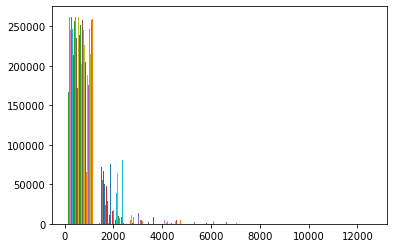

In [8]:
# image Histogram 
plt.hist(matfiles_df['image'])

(array([[512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0.,  76., 152., 228., 304., 380., 456., 532., 608., 684., 760.]),
 <a list of 512 BarContainer objects>)

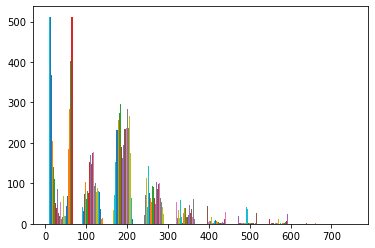

In [48]:
plt.hist(matfiles_df['image'][0])

(array([2330., 1765., 1985., 1445., 1355., 1530., 1760., 1650., 1005.,
         495.]),
 array([  0. ,  23.2,  46.4,  69.6,  92.8, 116. , 139.2, 162.4, 185.6,
        208.8, 232. ]),
 <BarContainer object of 10 artists>)

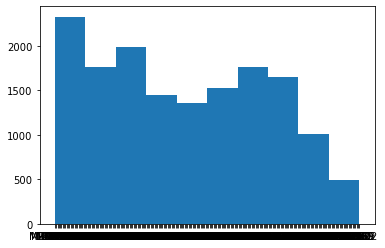

In [52]:
# PID Histogram 
plt.hist(matfiles_df['PID'])

(array([3540.,    0.,    0.,    0.,    0., 7130.,    0.,    0.,    0.,
        4650.]),
 array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4000000000000004, 2.6, 2.8,
        3.0], dtype=object),
 <BarContainer object of 10 artists>)

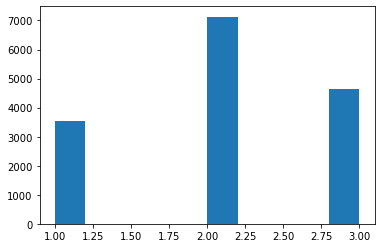

In [53]:
# label Histogram 
plt.hist(matfiles_df['label'])

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0., 22., ...,  0.,  0.,  0.],
        [ 0.,  0., 22., ...,  0.,  0.,  0.],
        [ 0.,  0., 22., ...,  0.,  0.,  0.]]),
 array([ 47.02740911,  89.3323337 , 131.6372583 , 173.94218289,
        216.24710749, 258.55203208, 300.85695667, 343.16188127,
        385.46680586, 427.77173046, 470.07665505]),
 <a list of 15320 BarContainer objects>)

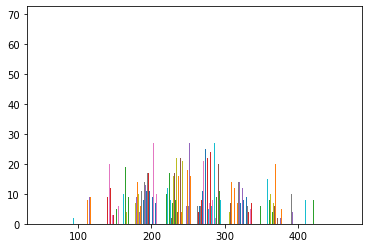

In [54]:
# tumorBorder Histogram 
plt.hist(matfiles_df['tumorBorder'])

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(array([[259616.,      0.,      0., ...,      0.,      0.,   2528.],
        [259616.,      0.,      0., ...,      0.,      0.,   2528.],
        [259616.,      0.,      0., ...,      0.,      0.,   2528.],
        ...,
        [261125.,      0.,      0., ...,      0.,      0.,   1019.],
        [261125.,      0.,      0., ...,      0.,      0.,   1019.],
        [261125.,      0.,      0., ...,      0.,      0.,   1019.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 15320 BarContainer objects>)

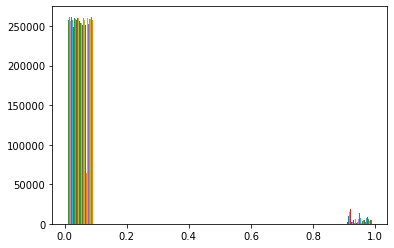

In [55]:
# tumorMask Histogram 
plt.hist(matfiles_df['tumorMask'])

In [62]:
cormat = matfiles_df.corr()
round(cormat,2)
cormat

""


In [84]:
#matfiles_df['image'] = matfiles_df['image'].astype(float)

In [5]:
# rows with 256X256 images
img_256 = []
for i in range(len(matfiles)):
    if matfiles_df['image'][i].shape[0] == 256:
        img_256.append(i)

In [6]:
# matfiles_df_no256 = matfiles_df.drop(index=img_256)
# images = matfiles_df_no256['image']
# images = np.dstack(images)
# images = np.rollaxis(images,-1)
# images_reshaped = images.reshape(len(images), -1)

#images = images/255.0


In [7]:
#images_reshaped.shape

(15245, 262144)

In [ ]:
# kmeans = KMeans(n_clusters=3,random_state=109)
# kmeans.fit(images_reshaped)


In [23]:
shp = []
for i in range(len(matfiles)):
    s = matfiles_df['image'][i].shape[0]
    shp.append(s)




(array([256, 512]), array([  1149000, 233553400]))

In [64]:
matfiles_df_no256 = matfiles_df.drop(index=img_256)
matfiles_df_no256.shape

(15245, 5)

In [47]:
#plt.imshow(matfiles_df['image'][15320])
#matfiles_df['image'].shape
num1, c1 = np.unique(shp, return_counts=True)  
num1, c1

(array([256, 512]), array([   75, 15245]))

In [48]:
shp = []
for i in range(len(matfiles)):
    s = matfiles_df['image'][i].shape[1]
    shp.append(s)

In [49]:
num2, c2 = np.unique(shp, return_counts=True)  
num2, c2

(array([256, 512]), array([   75, 15245]))